# **Amazon stock price analysis**

Throughout the following notebook we will analyze the closing prices for Amazon stocks from May 1997 through to September 2020. I have also created and implemented a predictive ARIMA model to forcast prices for this data.

In the following exploratory data analysis (EDA) I will answer my hypotheses about the data which will be laid out in the introduction priory to seeing the data to avoid any bias. 

Time-series analysis is commonly used in the real world because of its implications. Whether it is predicting stock prices, weather changes, sea levels, or even traffic, it can provide a key insight into what the future holds.


### Hypothesis generation:

1. The stock closing prices will drop in March 2020. Around March 2020 is when the coronavirus really took effect in America, therefore I would pressume this lead to a crash in stock prices. 


2. The stock closing prices will increase each year on average around the last few months of the year. This will be down to spending increasing in preparation for Christmas.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

# 1. The Data

We will first begin by importing the data into a dataframe format and inspecting it further.

Below is a brief description of each column:

- Date: The date of each row.
- Open: Open price in dollars.
- High: High price in dollars.
- Low: Low price in dollars.
- Close: Close price adjusted for splits.
- Adj Close: Adjusted close price adjusted for both dividends and splits.
- Volume: Volume in this day

In [2]:
# Load data
amazon = pd.read_csv('/Users/Rhys/Desktop/Time-Series Project/AMZN.csv')

In [3]:
# Examine Dataframe
amazon.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [4]:
amazon.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5874,2020-09-17,3009.250000,3029.429932,2972.550049,3008.729980,3008.729980,6449100
5875,2020-09-18,3031.739990,3037.800049,2905.540039,2954.909912,2954.909912,8892600
5876,2020-09-21,2906.500000,2962.000000,2871.000000,2960.469971,2960.469971,6117900
5877,2020-09-22,3033.840088,3133.989990,3000.199951,3128.989990,3128.989990,6948800
5878,2020-09-23,3120.429932,3127.000000,2992.379883,2999.860107,2999.860107,5630400


In [5]:
amazon.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5879.000000,5879.000000,5879.000000,5879.000000,5879.000000,5.879000e+03
mean,390.664841,395.110673,385.752844,390.646958,390.646958,7.501785e+06
std,625.928151,632.734659,618.059396,625.706916,625.706916,7.264030e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,38.056249,38.750000,37.355000,38.029998,38.029998,3.684900e+06
50%,84.250000,85.625000,82.510002,84.187500,84.187500,5.644500e+06
75%,370.330002,373.315002,366.440002,370.544999,370.544999,8.505450e+06
max,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,1.043292e+08


In [6]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5879 entries, 0 to 5878
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5879 non-null   object 
 1   Open       5879 non-null   float64
 2   High       5879 non-null   float64
 3   Low        5879 non-null   float64
 4   Close      5879 non-null   float64
 5   Adj Close  5879 non-null   float64
 6   Volume     5879 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 321.6+ KB


# 2. Data Cleaning/Wrangling

Upon inspection we see that the dataframe consists of 5879 rows and 7 columns. We will need to reindex the dataframe so that the 'Date' column is the index thus allowing us to continue our time series analysis. This will also need to be changed to a dtype of Datetime. 

The data does not appear to contain any missing values and appears relatively clean. 

We will also add in a column for each the Year, Month, and Day to help with our EDA.

In [7]:
# Change dtype to datetime and reindex
amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon = amazon.set_index('Date')

In [8]:
amazon['Year'] = amazon.index.year
amazon['Month'] = amazon.index.month
amazon['Day'] = amazon.index.day

In [9]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5879 entries, 1997-05-15 to 2020-09-23
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5879 non-null   float64
 1   High       5879 non-null   float64
 2   Low        5879 non-null   float64
 3   Close      5879 non-null   float64
 4   Adj Close  5879 non-null   float64
 5   Volume     5879 non-null   int64  
 6   Year       5879 non-null   int64  
 7   Month      5879 non-null   int64  
 8   Day        5879 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 459.3 KB


In [10]:
amazon.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,1997,5,15
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,1997,5,16
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,1997,5,19
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,1997,5,20
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1997,5,21


# 3. Exploratory Data Analysis

We will start our EDA by visualizing the mean closing prices over the past 20 years.

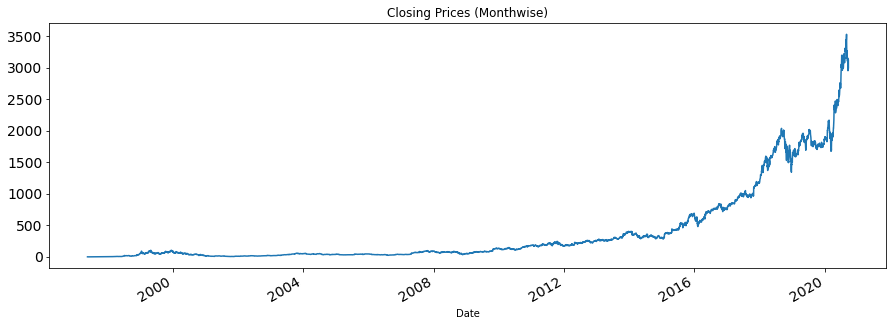

In [11]:
closing_mean = amazon.groupby(['Date'])['Close'].mean() 
closing_mean.plot(figsize=(15,5), title= 'Closing Prices (Monthwise)', fontsize=14)

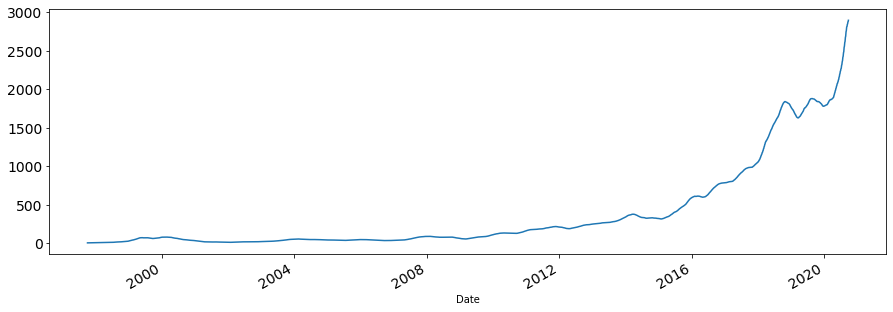

In [12]:
closing_mean.rolling(window=100).mean().plot(figsize=(15,5), fontsize=14)

As we can see from the above two plots Amazons stock prices have grown exponentially over the last 20 years, especiallu in recent years. 

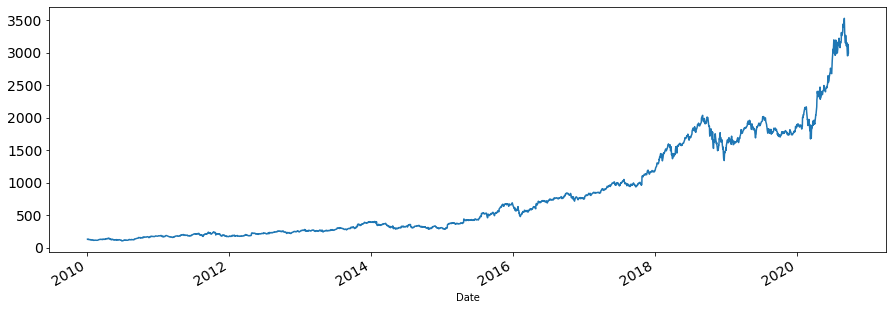

In [13]:
amazon['Close'].loc['2010':'2020'].plot(figsize=(15,5), fontsize=14)

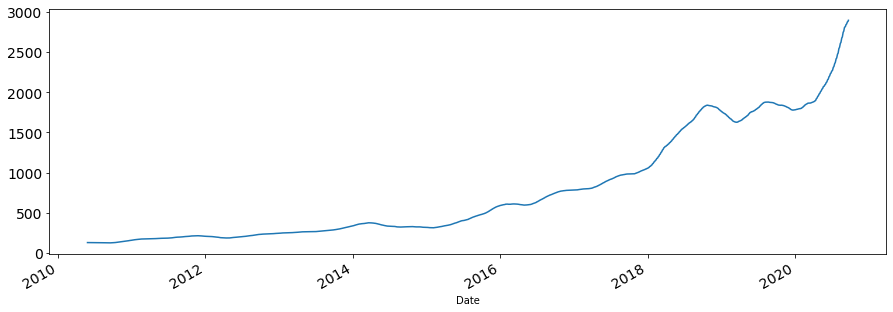

In [14]:
amazon['Close'].loc['2010':'2020'].rolling(window=100).mean().plot(figsize=(15,5), fontsize=14)

From the above two plots we can see a small plato appears to have occured throughout 2019 after a sudden rise in late 2018.

Lets move on to some EDA to help prove or disprove our original hypotheses.

First lets take a closer look at recent years.

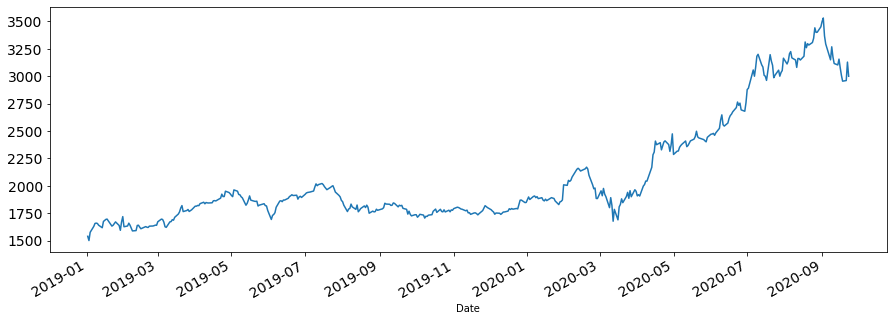

In [15]:
amazon['Close'].loc['2019':'2020'].plot(figsize=(15,5), fontsize=14)

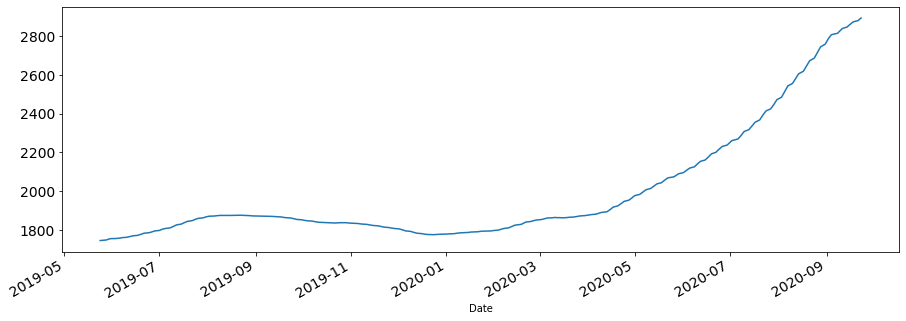

In [16]:
amazon['Close'].loc['2019':'2020'].rolling(window=100).mean().plot(figsize=(15,5), fontsize=14)

Below is a granular look at months when Covid started (Feb, March, April, May) in 2020

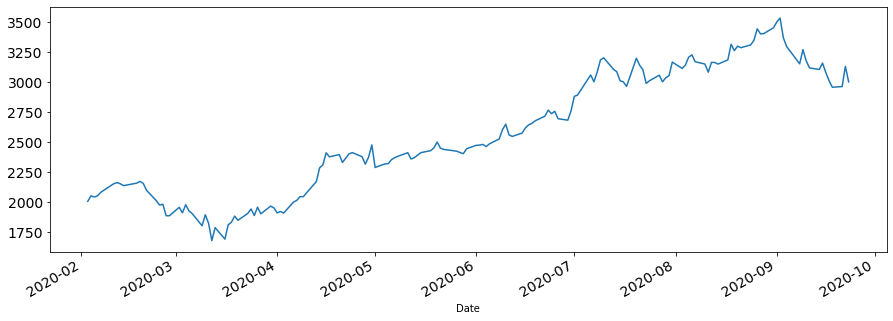

In [17]:
amazon['Close'].loc['2020-02':'2020-09'].plot(figsize=(15,5), fontsize=14)

From the above graphs it becomes apparent that there was certainly a drop in closing price as a result of the coronavirus. Therefore we can confirm our first hypothesis was correct. 

Next we can move onto the hypothesis of highest close prices around Christmas months/end of the year.

As we are taking the mean monthly price into account here, the years 1997 and 2020 will be excluded as we do not have sufficient data for those to be complete. Therefore we will take the mean closing price each month from 1998 - 2019.

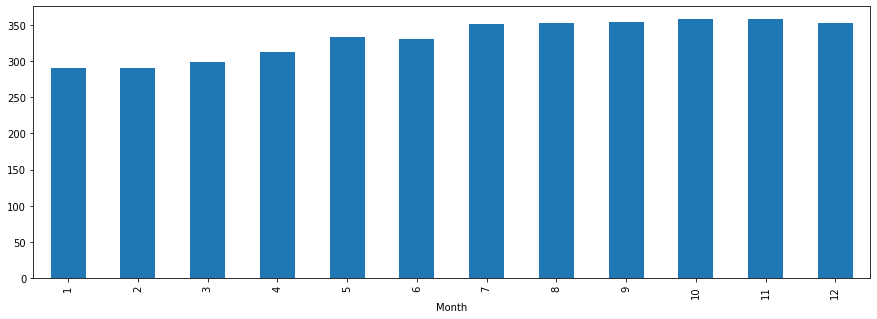

In [18]:
amazon.loc['1998':'2019'].groupby('Month')['Close'].mean().plot.bar()

It is clear in the above graph that the closing price certainly increases on average towards the end of the year. Therefore we can confirm our second hypothesis is correct.

# 4. Model

For the modelling stage we will be implementing the common but powerful method of ARIMA. 

This stands for Auto Regressive Integrated Moving Average.

For ARIMA modelling we will need to check that our data is stationary, for this to be true the data must have:

- Constant mean
- Constant variance
- Autocovariance that does not depend on time

We can also implement the statistical Dickey Fuller test to see if the dataset is stationary or not. 

In [19]:
# We are only focusing on the closing price so we can drop the remaining columns from our data

amazon = amazon[['Close']]

In [20]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
 #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print('Results of dickey fuller test')
    result = adfuller(timeseries, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

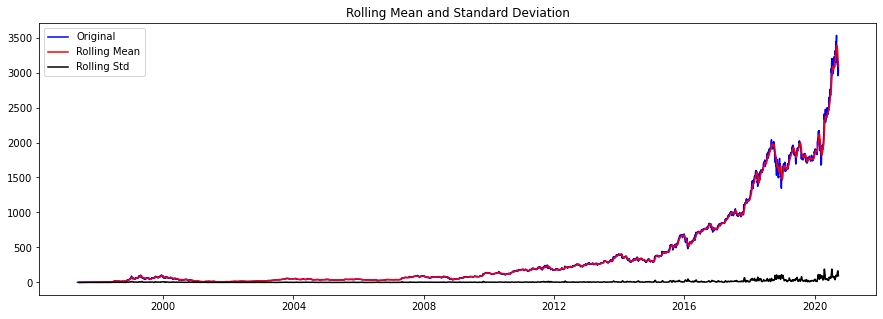

Results of dickey fuller test
Test statistic:  4.394337547449679
p-value:  1.0
Critical Values: {'1%': -3.4314694686299707, '5%': -2.8620346998076935, '10%': -2.567033326602315}


In [21]:
test_stationarity(amazon)

As we can see this dataset is certainly not stationary as we had already discovered in our EDA above. 

To make the series stationary, we remove the trend and seasonality from the data. The resultant series will become stationary through this process.

We can also implement the seasonal_decompose method to display the original, seasonal, trend, and residual plots for our data. This allows us to visualize the issues with our data that need addressing.

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

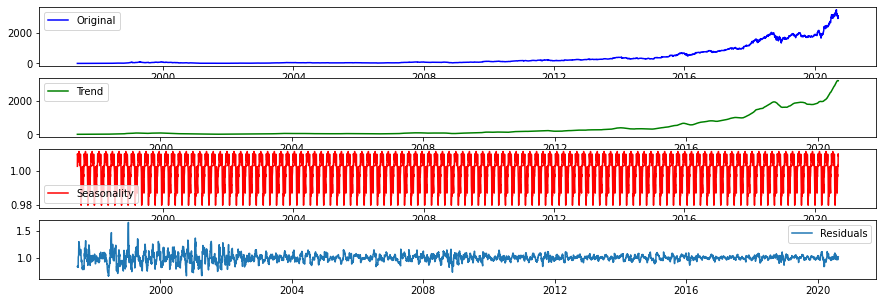

In [22]:
decomposition = seasonal_decompose(amazon, model='multiplicative', period=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(amazon, 'blue', label = 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, 'green', label = 'Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, 'red', label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout

We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example, log transformation.

In [23]:
amazon_log = np.log(amazon)
moving_avg = amazon_log.rolling(12).mean()

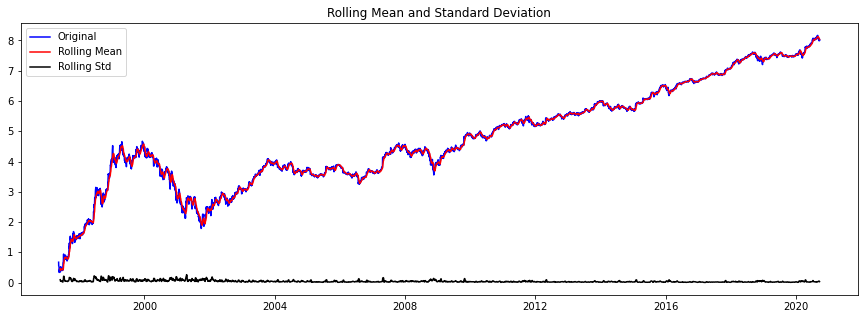

Results of dickey fuller test
Test statistic:  -1.5586797971446047
p-value:  0.5043097204868637
Critical Values: {'1%': -3.4314694686299707, '5%': -2.8620346998076935, '10%': -2.567033326602315}


In [24]:
test_stationarity(amazon_log)

The above results still show that the data is not stationary as we expect to see a p-value of below 5% and a test statistic below the critical values. Therefore more work needs to be done.

We will do this by finding the difference between our data and the moving average, thus removing the trend further.

In [25]:
amazon_log_moving_avg_diff = amazon_log - moving_avg

The rolling window used averaged 100 values, this means that the first 99 values will be null, therefore these must be dropped. 

In [26]:
amazon_log_moving_avg_diff.dropna(inplace = True)

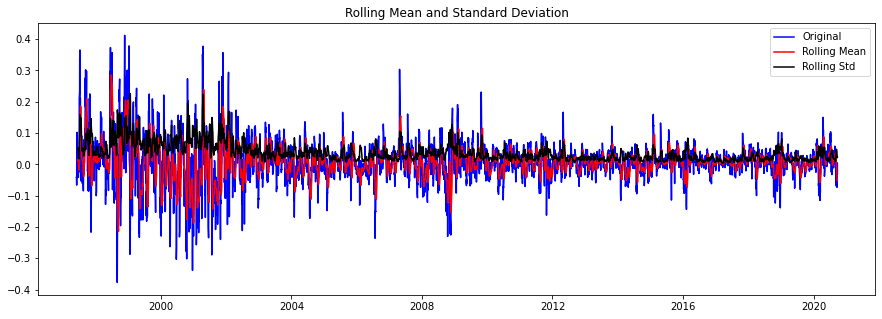

Results of dickey fuller test
Test statistic:  -11.3445104705911
p-value:  1.0349926973928952e-20
Critical Values: {'1%': -3.431471580678736, '5%': -2.8620356329584897, '10%': -2.567033823344827}


In [27]:
test_stationarity(amazon_log_moving_avg_diff)

We can see that the Test Statistic is less than the Critical Value and the p-value is less than 5%. So, we can be confident that the trend is removed.

Next we will split the data into training and testing sets. This will be a 80/20 split.

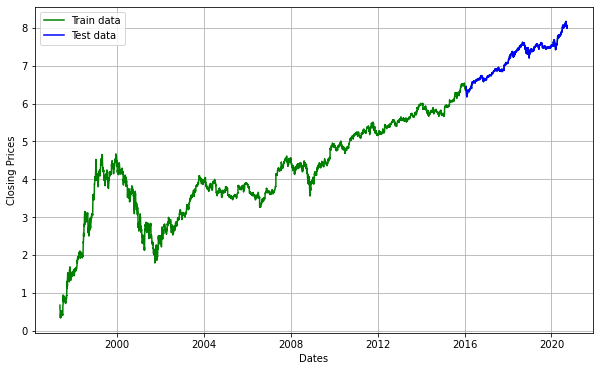

In [28]:
train_data, test_data = amazon_log[3:int(len(amazon_log)*0.8)], amazon_log[int(len(amazon_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(amazon_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Now we have our data sets split up we can start training our ARIMA model. 

We will begin with auto_arima, this is a method of finding the best model to fit our data without having to produce ACF and PACF graphs. 

We will train this and then look at the summary to determine which ARIMA model to implement. The summary stats are based on a AIC score with a lower score being a more successful model.

In [29]:
model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=False, d=1, D=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16955.289, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16956.520, Time=1.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16954.781, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16954.800, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16953.849, Time=0.47 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 6.150 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4700
Model:               SARIMAX(0, 1, 0)   Log Likelihood                8480.260
Date:                Sun, 03 Jan 2021   AIC                         -16956.520
Time:                        18:18:02   BIC                         -16943.609
Sample:                             0   HQIC                        -16951.981
                               - 4700                             

We see that the best model for our data set is the ARIMA (0,1,0) model.

Lets take a look at the residualplots from our auto arima before progressing.

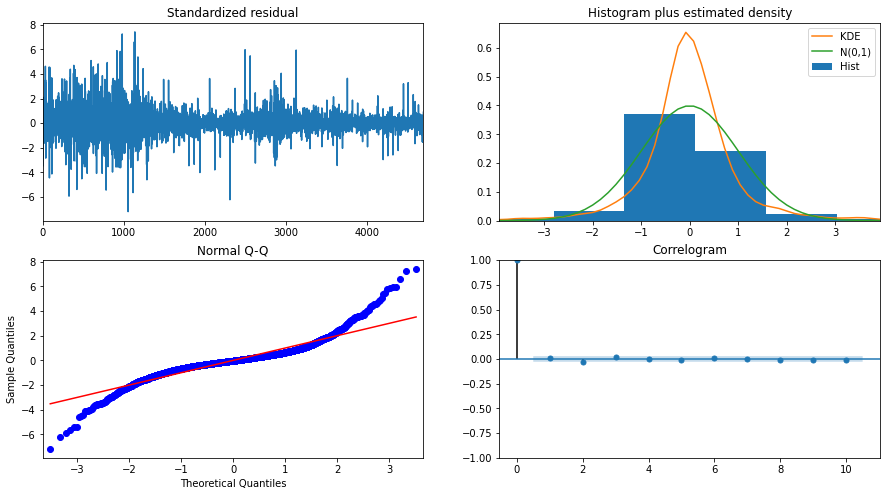

In [30]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Starting with the top left we see that the residual errors seem to fluctuate around a mean of zero with a constant variance, this is a good sign that our model is a good fit.

Next we have the density plot in the top right corner, from this we can see a gaussian distribution with mean zero, another good sign.

For the graph in the bottom left we should see all points falling along the line, the deviations we see suggest the distribution is skewed.

Finally in the bottom right we see ACF plot. This shows we have no autocorrelation which is also a good sign.

All in all this model appears to be a good fit.

Lets fit our model.

In [31]:
# Fit model

model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4699
Model:                 ARIMA(0, 1, 0)   Log Likelihood                8480.260
Method:                           css   S.D. of innovations              0.040
Date:                Sun, 03 Jan 2021   AIC                         -16956.520
Time:                        18:18:07   BIC                         -16943.609
Sample:                             1   HQIC                        -16951.981
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.162      0.031       0.000       0.002


# 5. Predictions 

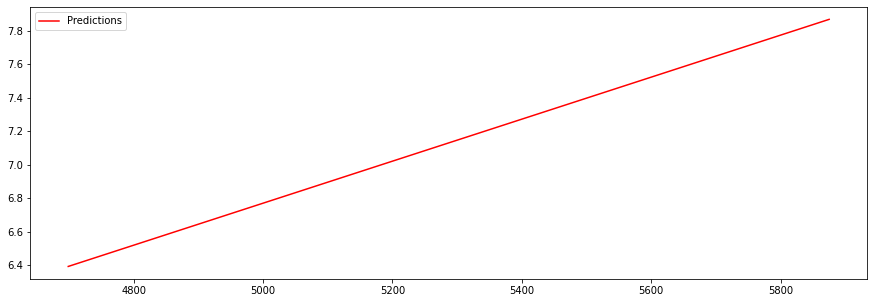

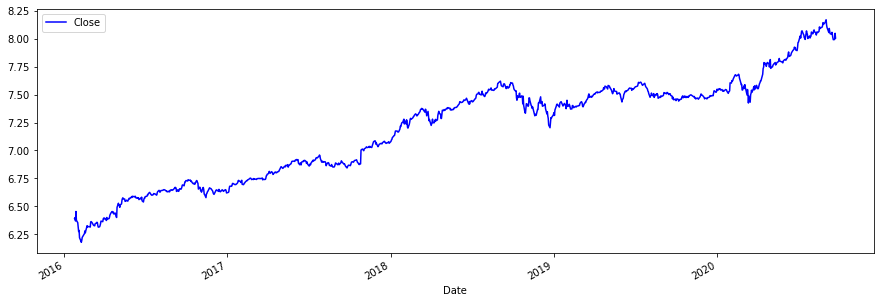

In [32]:
start = len(train_data) 
end = len(train_data) + len(test_data)
  
predictions = fitted.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(color='red', legend = 'True') 
test_data.plot(color = 'blue', legend='True') 

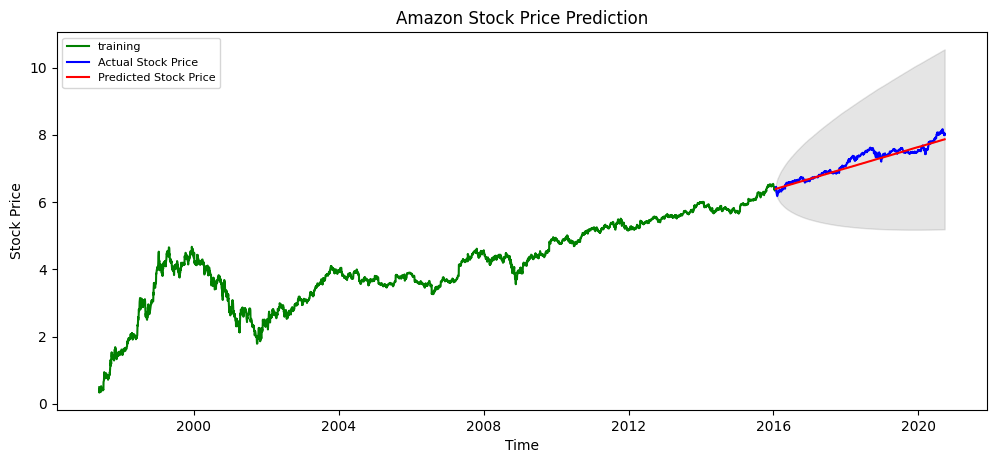

In [33]:
fc, se, conf = fitted.forecast(1176, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, color = 'green', label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As we can see from our predicted stock prices compared to the actual test data our model appears to be succesful. We can look further into this by looking at the metrics below.

In [34]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))


MSE: 0.02094676350011847
MAE: 0.11055156302345584
RMSE: 0.14472996752614323


# 6. Conclusion

## Key points

From this notebook I aimed to dive into the Amazon stock prices and discover current trends. I found that on average over the years the closing prices for Amazons stock prices certainly were higher towards the tail end of the year leading towards the holidays such as Christmas. This was a predicted trend from my original hypothesis. We also confirmed our hypothesis of the impact of the coronavirus on the closing prices, this was shown in the EDA portion of the notebook. 

## Predictive models

We followed the Box jenkinks method and implemented the ARIMA model for our predictive model. This led to a mean absolute error (MAE) of only 0.11, indicating this is a successful model.

## Future project

In the future I would like to work with this data set again but this time also work with weather data to see how this can effect the Amazon stock prices. 